<a href="https://colab.research.google.com/github/JCPY6235/Advanced-Python/blob/main/Assignment3_GPU_JeanClaude.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> # Nom: **MITCHOZOUNOU**

> # Prénoms: **SAgbo Jean-Claude**

> ## Matière: **HPC**

> ## TP3: GPU Acceleration

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

> # Exercise 1:

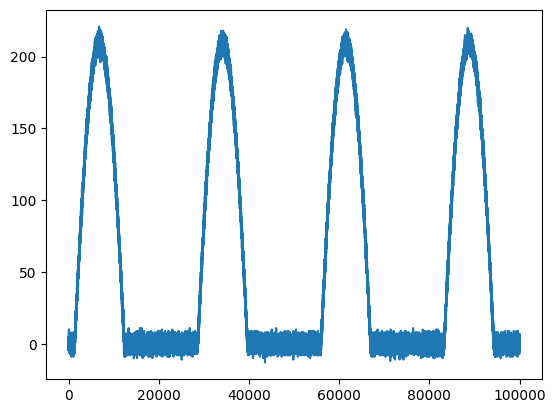

In [ ]:
# This allows us to plot right here in the notebook
%matplotlib inline
# Hacking up a noisy pulse train
from matplotlib import pyplot as plt
n = 100000
noise = np.random.normal(size=n) * 3
pulses = np.maximum(np.sin(np.arange(n) / (n / 23)) - 0.3, 0.0)
waveform = ((pulses * 300) + noise).astype(np.int16)
plt.plot(waveform)

In [ ]:
print(waveform)


[ 0  5 -5 ...  1  5  1]


/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 98 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


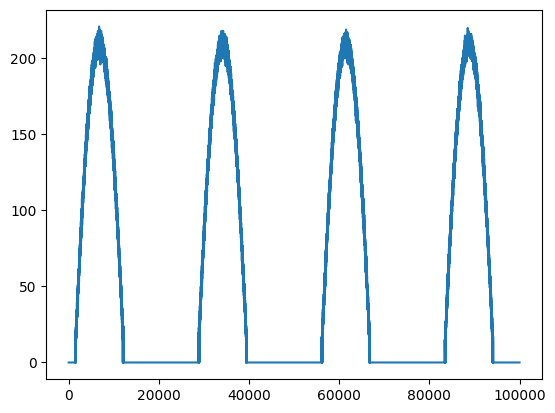

In [ ]:
from numba import vectorize, cuda

@vectorize(['int16(int16, int16)'], target = 'cuda')

def zero_suppress(waveform_value, threshold):
    if waveform_value < threshold:
        result = 0
    else:
        result = waveform_value
    return result
# This will throw an error until you successfully vectorize the `zero_suppress` function above.
# The noise on the baseline should disappear when zero_suppress is implemented

#waveform_Noise_supp = [zero_suppress(wave_val, 15) for wave_val in waveform]
#plt.plot(waveform_Noise_supp)
plt.plot(zero_suppress(waveform, 15))

> ## Exercise 2: Optimize Memory Movement

In [ ]:
import math
@vectorize(['float32(float32, float32, float32)'], target = 'cuda')
def make_pulses(i, period, amplitude):
    return max(math.sin(i / period) - 0.3, 0.0) * amplitude

@vectorize(['float32(float32, float32)'], target='cuda')
def add_ufunc(a,b):
  return a+b
n = 100000
noise = (np.random.normal(size=n) * 3).astype(np.float32)
t = np.arange(n, dtype=np.float32)
period = n / 23

In [ ]:
device_noise = cuda.to_device(noise)
device_t = cuda.to_device(t)
device_pulses = cuda.device_array(shape=(n,), dtype=np.float32)



In [ ]:
device_pulses.dtype

dtype('float32')

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 98 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 98 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


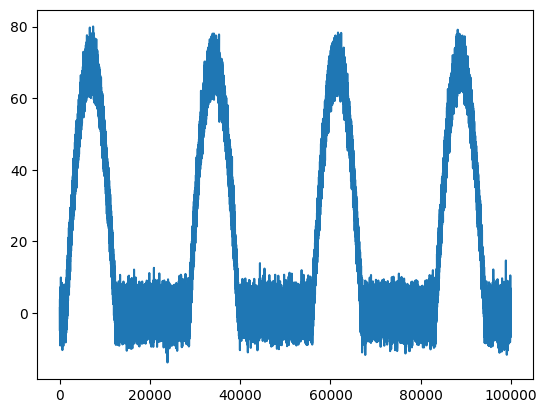

In [ ]:
make_pulses(device_t, period, 100.0, out=device_pulses)
waveform = add_ufunc(device_pulses, device_noise)
waveform = waveform.copy_to_host()
%matplotlib inline
from matplotlib import pyplot as plt
plt.plot(waveform)

> ## Exercice 3:

In [ ]:
# Our hidden layer will contain 1M neurons.

n = 1000000

greyscales = np.floor(np.random.uniform(0, 255, n).astype(np.float32))
weights = np.random.normal(.5, .1, n).astype(np.float32)


> ## **Let modify these 3 function calls to run on the GPU.**

In [ ]:
from math import exp
@vectorize(['float32(float32)'], target='cuda')
def normalize(grayscales):
    return grayscales / 255

@vectorize(['float32(float32,float32)'], target='cuda')
def weigh(values, weights):
    return values * weights

@vectorize(['float32(float32)'], target='cuda')
def activate(values):
    return ( exp(values) - exp(-values) ) / ( exp(values) + exp(-values) )



> ## **Let modify the body of the following function to optimize data transfers and therefore speed up performance**

In [ ]:
def create_hidden_layer(n, greyscales, weights, exp, normalize, weigh, activate):

    device_greyscales = cuda.to_device(greyscales)
    device_weights = cuda.to_device(weights)

    normalized = normalize(device_greyscales)
    weighted = weigh(normalized, device_weights)
    activated = activate(weighted)

    # The assessment mechanism will expect `activated` to be a host array, so,
    # even after you refactor this code to run on the GPU, make sure to explicitly copy
    # `activated` back to the host.
    out_host = activated.copy_to_host()
    return activated